<a href="https://colab.research.google.com/github/ethanyoum/Tesla-Predictions/blob/main/5DayReturn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary libraries
import time
import yfinance as yf
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Engineering & Pruning

In [2]:
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Download TSLA + external indicators
start_date = '2015-12-14'
end_date = '2025-04-30'
data = yf.download('TSLA', start = start_date, end = end_date)

# Create target: next-day return of TSLA
data['TSLA_5d_return'] = data['Close'].pct_change(periods = 5).shift(-5)

# Macro/external indicators
macro_tickers = ['SPY', 'USO', '^VIX', '^TNX', 'QQQ']
macro_raw = yf.download(macro_tickers, start=start_date, end=end_date)

# Flatten Close prices only and fix column names
macro_data = macro_raw['Close'].copy()
macro_data.columns = [col.replace('^', '') for col in macro_data.columns]
macro_data = macro_data.rename(columns={'TNX': 'US10Y'})

# Both idx to be aligned
macro_data.index = macro_data.index.tz_localize(None)
data.index = data.index.tz_localize(None)

# Flatten data columns
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

# Optional: rename for clarity
data = data.rename(columns={
    'Open': 'TSLA_Open',
    'High': 'TSLA_High',
    'Low': 'TSLA_Low',
    'Close': 'TSLA_Close',
    'Adj Close': 'TSLA_AdjClose',
    'Volume': 'TSLA_Volume'
})

# Join all of them
data = data.join(macro_data)

# Drop the last row since it has NaN in the target
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  5 of 5 completed


In [3]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=feef87c90d069f878d4ead1afbfeeb3d3c42dfe050c1468754eae62b1b922d86
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.momentum import ROCIndicator

lookahead = 5

# Add technical indicators
data['RSI'] = RSIIndicator(data['Close_TSLA'], window = 14).rsi().shift(lookahead)
data['MACD'] = MACD(data['Close_TSLA']).macd().shift(lookahead)
Bollinger_Bands = BollingerBands(data['Close_TSLA'])
data['BB_high'] = Bollinger_Bands.bollinger_hband().shift(lookahead)
data['BB_low'] = Bollinger_Bands.bollinger_lband().shift(lookahead)

In [4]:
# Volume (normalized) & Earnings Date
data['Volume_norm'] = ((data['Volume_TSLA'] - data['Volume_TSLA'].rolling(20).mean()) / data['Volume_TSLA'].rolling(20).std()
).shift(lookahead)

earnings_dates = [
    '2016-02-10', '2016-05-04', '2016-08-03', '2016-10-26',
    '2017-02-22', '2017-05-03', '2017-08-02', '2017-11-01',
    '2018-02-07', '2018-05-02', '2018-08-01', '2018-10-24',
    '2019-01-30', '2019-04-24', '2019-07-24', '2019-10-23',
    '2020-01-29', '2020-04-29', '2020-07-22', '2020-10-21',
    '2021-01-27', '2021-04-26', '2021-07-26', '2021-10-20',
    '2022-01-26', '2022-04-20', '2022-07-20', '2022-10-19',
    '2023-01-25', '2023-04-19', '2023-07-19', '2023-10-18',
    '2024-01-24', '2024-04-23', '2024-07-23', '2024-10-23',
    '2025-01-29']

data['Earnings'] = data.index.isin(pd.to_datetime(earnings_dates)).astype(int)

In [5]:
# Seasonality
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month
data['Quarter'] = data.index.quarter

In [6]:
# Momentum indicators
data['ROC'] = ROCIndicator(data['Close_TSLA']).roc()
stoch = StochasticOscillator(data['High_TSLA'], data['Low_TSLA'], data['Close_TSLA'])

# Stoch_K (%K) = Raw Stochastic Oscillator value, Stoch_D (%D) = Moving average of %K
data['Stoch_K'] = stoch.stoch().shift(lookahead)
data['Stoch_D'] = stoch.stoch_signal().shift(lookahead)

In [7]:
# Regime Indicators
data['rolling_vol'] = data['Close_TSLA'].rolling(window = 20).std().shift(lookahead)
data['rolling_mean'] = data['Close_TSLA'].rolling(window = 20).mean().shift(lookahead)

In [8]:
# Lagged Returns
data['lag_1'] = data['Close_TSLA'].pct_change(1).shift(1)
data['lag_2'] = data['Close_TSLA'].pct_change(1).shift(2)
data['lag_3'] = data['Close_TSLA'].pct_change(1).shift(3)

In [9]:
## Feature Pruning
# Drop less useful or problematic columns
drop_cols = ['Open_TSLA', 'Volume_TSLA','High_TSLA', 'Low_TSLA', 'rolling_mean',
    'BB_high', 'BB_low', 'lag_2', 'lag_3', 'Day_of_Week', 'Month', 'Quarter']
data.drop(columns = [col for col in drop_cols if col in data.columns], inplace = True)
data.dropna(inplace = True)

In [10]:
# Finalize dataframe
data = data.rename(columns = {'TSLA_5d_return_': 'TSLA_5d_return'})
features = data.drop(columns = ['TSLA_5d_return'])
#target = data[['TSLA_5d_return']]

# Scale features
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns, index=features.index)

#target_scaler = RobustScaler()
#target_scaled = target_scaler.fit_transform(target)
#data['TSLA_5d_return_scaled'] = target_scaled

In [11]:
data['direction'] = (data['TSLA_5d_return'] > 0).astype(int)
target = data['direction'].values.astype(np.float32)

In [12]:
features.head(10)

,Close_TSLA,QQQ,SPY,USO,US10Y,VIX,RSI,MACD,Volume_norm,Earnings,ROC,Stoch_K,Stoch_D,rolling_vol,lag_1
Date,,,,,,,,,,,,,,,
2016-01-28,12.646667,95.208992,161.673798,77.599998,1.985,22.420000,31.943029,-0.420907,-0.279700,0,-8.732259,16.704978,17.831706,0.916591,-0.028363
2016-01-29,12.746667,97.197189,165.614960,77.199997,1.931,20.200001,35.906268,-0.421308,-0.351110,0,-8.939372,28.158479,19.695483,0.923898,0.008667
2016-02-01,13.129333,97.458542,165.555176,72.160004,1.966,19.980000,31.223438,-0.449634,-0.685460,0,-1.682399,14.393937,19.752465,0.946739,0.007907
2016-02-02,12.185333,95.348991,162.571472,68.559998,1.864,21.980000,29.340020,-0.481700,0.754208,0,-11.349303,14.828910,19.127109,0.964475,0.030021
2016-02-03,11.565333,94.891617,163.546097,74.720001,1.881,21.650000,26.046070,-0.530530,-0.326861,0,-15.371484,6.633952,11.952266,0.999201,-0.071900
2016-02-04,11.688667,94.882309,163.802551,72.959999,1.864,21.840000,28.608784,-0.554073,0.373357,0,-14.356188,19.169047,13.543970,0.958588,-0.050881
2016-02-05,10.840000,91.587311,160.682144,71.279999,1.848,23.379999,30.979122,-0.558226,-1.002782,0,-18.168093,27.434437,17.745812,0.873099,0.010664
2016-02-08,9.866000,90.187164,158.519135,69.120003,1.735,26.000000,39.286320,-0.524593,0.873674,0,-25.993897,46.377216,30.993567,0.704256,-0.072606
2016-02-09,9.883333,89.907158,158.527710,65.440002,1.729,26.540001,29.767995,-0.567569,1.419969,0,-26.808195,7.865516,27.225723,0.705204,-0.089852


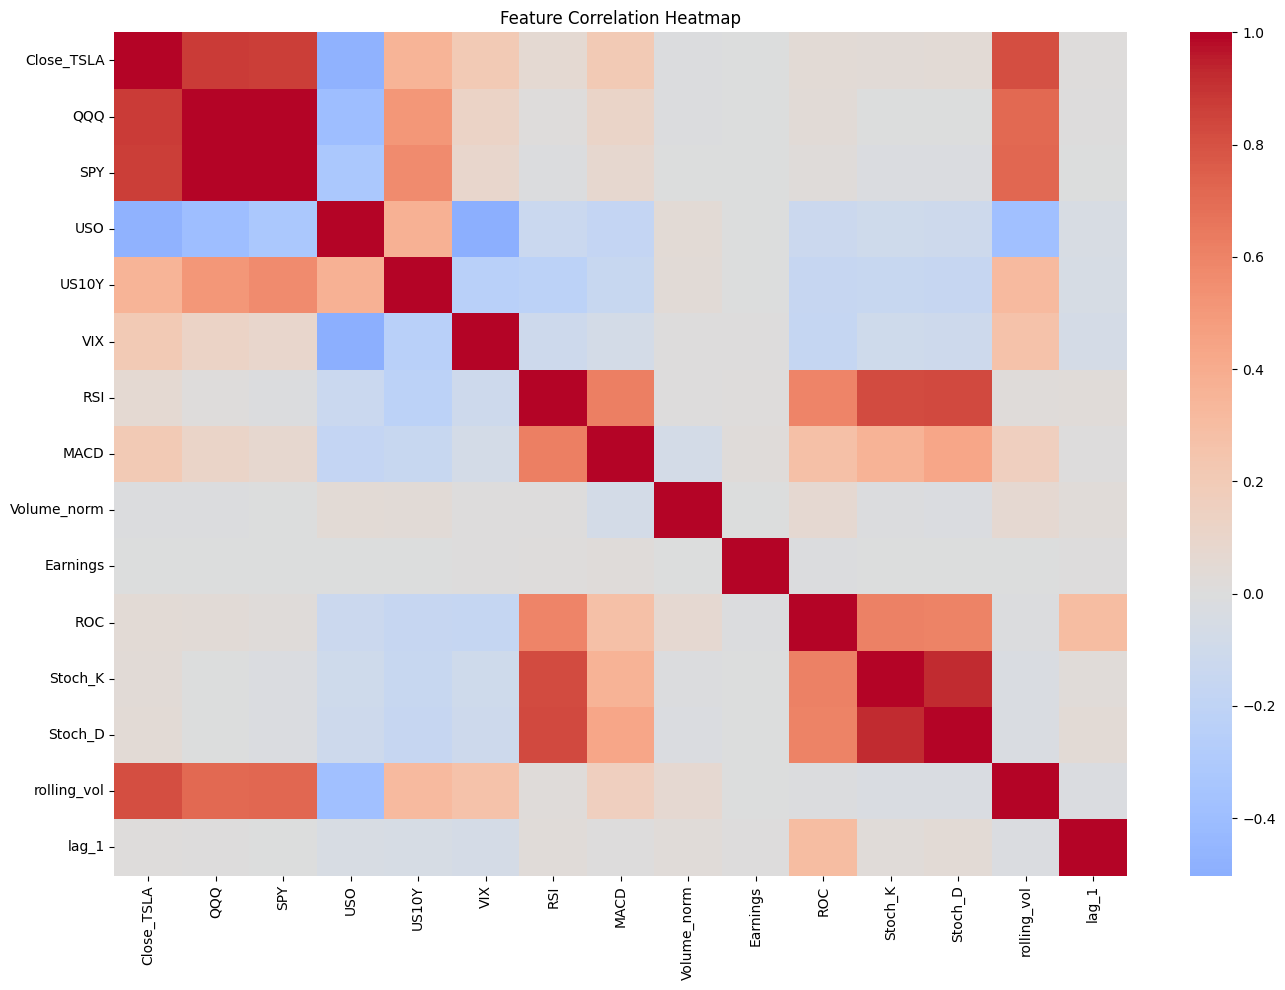

In [13]:
# 1) Feature correlation check
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(features_scaled.corr(), cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [14]:
target_series = pd.Series(target, index=features_scaled.index, name='direction')

In [15]:
data_final = pd.concat([features_scaled, target_series], axis = 1)

In [16]:
data_final

,Close_TSLA,QQQ,SPY,USO,US10Y,VIX,RSI,MACD,Volume_norm,Earnings,ROC,Stoch_K,Stoch_D,rolling_vol,lag_1,direction
Date,,,,,,,,,,,,,,,,
2016-01-28,-0.513476,-0.855504,-0.849923,0.032179,-0.232718,0.706876,-1.050890,-0.160690,-0.045626,0.0,-0.631304,-0.704526,-0.725806,-0.365953,-0.797269,0.0
2016-01-29,-0.513012,-0.845354,-0.827937,0.015886,-0.261214,0.439083,-0.836186,-0.160803,-0.101162,0.0,-0.644334,-0.505636,-0.691560,-0.365393,0.199113,0.0
2016-02-01,-0.511235,-0.844020,-0.828271,-0.189409,-0.242744,0.412545,-1.089873,-0.168772,-0.361190,0.0,-0.187769,-0.744657,-0.690513,-0.363642,0.178672,0.0
2016-02-02,-0.515619,-0.854789,-0.844915,-0.336049,-0.296570,0.653800,-1.191905,-0.177793,0.758455,0.0,-0.795952,-0.737104,-0.702003,-0.362282,0.773687,0.0
2016-02-03,-0.518498,-0.857124,-0.839478,-0.085132,-0.287599,0.613993,-1.370351,-0.191531,-0.082303,0.0,-1.049004,-0.879410,-0.833838,-0.359620,-1.968722,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-15,0.607822,0.996526,1.247199,-0.420774,1.001055,1.635706,-0.845634,-3.868844,0.905660,0.0,-0.307271,-0.824315,-0.692125,1.079969,-0.029824,0.0
2025-04-16,0.549496,0.926024,1.180537,-0.369043,0.977836,1.939687,-0.005520,-3.138356,1.780477,0.0,-0.509425,0.302174,-0.385721,1.109306,0.153572,1.0
2025-04-17,0.548660,0.925616,1.184721,-0.298574,1.006332,1.579011,-0.262927,-2.975123,0.876431,0.0,-0.716780,-0.140903,-0.234889,1.089287,-1.364046,1.0


In [17]:
## Save the dataframe
data_final.to_parquet('DATA.parquet')
data_final.to_csv('DATA.csv')

In [2]:
data_final = pd.read_csv('DATA.csv')

In [17]:
data_final.head(5)

,Close_TSLA,QQQ,SPY,USO,US10Y,VIX,RSI,MACD,Volume_norm,Earnings,ROC,Stoch_K,Stoch_D,rolling_vol,lag_1,direction
Date,,,,,,,,,,,,,,,,
2016-01-28,-0.513476,-0.855504,-0.849923,0.032179,-0.232718,0.706876,-1.050890,-0.160690,-0.045626,0.0,-0.631304,-0.704526,-0.725806,-0.365953,-0.797269,0.0
2016-01-29,-0.513012,-0.845354,-0.827937,0.015886,-0.261214,0.439083,-0.836186,-0.160803,-0.101162,0.0,-0.644334,-0.505636,-0.691560,-0.365393,0.199113,0.0
2016-02-01,-0.511235,-0.844020,-0.828271,-0.189409,-0.242744,0.412545,-1.089873,-0.168772,-0.361190,0.0,-0.187769,-0.744657,-0.690513,-0.363642,0.178672,0.0
2016-02-02,-0.515619,-0.854789,-0.844915,-0.336049,-0.296570,0.653800,-1.191905,-0.177793,0.758455,0.0,-0.795952,-0.737104,-0.702003,-0.362282,0.773687,0.0
2016-02-03,-0.518498,-0.857124,-0.839478,-0.085132,-0.287599,0.613993,-1.370351,-0.191531,-0.082303,0.0,-1.049004,-0.879410,-0.833838,-0.359620,-1.968722,0.0


In [18]:
data_final.shape

(2321, 16)

# Split the Data

In [19]:
def data_split_multivariate_return(df, lookback):
    """
    Splits multivariate time series data into training and testing sets for 5-day return prediction.

    Args:
        df (pd.DataFrame): Feature-enhanced DataFrame with target in the last column.
        lookback (int): Number of past time steps to use for prediction.

    Returns:
        x_train, y_train, x_test, y_test: Torch-ready numpy arrays.
    """
    raw_data = df.to_numpy()
    x, y = [], []

    for i in range(len(raw_data) - lookback):
        x.append(raw_data[i:i+lookback, :-1])
        y.append(raw_data[i+lookback-1, -1])

    x = np.array(x)
    y = np.array(y).reshape(-1, 1)

    test_size = int(0.2 * len(x))
    x_train, y_train = x[:-test_size], y[:-test_size]
    x_test, y_test = x[-test_size:], y[-test_size:]

    return x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1, 1)

In [20]:
data_final = data_final.dropna()

In [21]:
x_train, y_train, x_test, y_test = data_split_multivariate_return(data_final, lookback=20)

In [22]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1841, 20, 15)
(460, 20, 15)
(1841, 1)
(460, 1)


#GRU-Based Return Direction Predictive Model

In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[:, -1, :])
        out = self.norm(out)
        return self.sigmoid(self.fc(out))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

def train_model(model, x_train, y_train, epochs=30, lr=0.00009, model_path=None, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train.to(device)).squeeze()
        targets = y_train.to(device).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if verbose and (epoch + 1) % 5 == 0:
            preds_binary = (outputs.detach().cpu().numpy() >= 0.5).astype(int)
            true_binary = y_train.cpu().numpy().astype(int).flatten()
            acc = accuracy_score(true_binary, preds_binary)
            print(f"Epoch [{epoch+1}/{epochs}]  Loss: {loss.item():.6f}  Acc: {acc:.4f}")

    # Save model
    if model_path:
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

    return model


In [25]:
def evaluate_model(model, x_test, y_test, show_plot=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(x_test.to(device)).squeeze()
        predicted_probs = outputs.cpu().numpy()
        predicted_labels = (predicted_probs >= 0.5).astype(int)
        true_labels = y_test.cpu().numpy().astype(int).flatten()

    # Metrics
    acc = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    if show_plot:
      plt.figure(figsize=(14, 6))

      plt.plot(predicted_probs, label='Predicted Probability', color='blue', linewidth=2)

      for i, val in enumerate(actual):
          if val == 1:
              plt.axvspan(i - 0.5, i + 0.5, color='orange', alpha=0.3)

      plt.title("TSLA Direction Prediction")
      plt.xlabel("Time Step")
      plt.ylabel("Probability / Direction")
      plt.ylim([-0.1, 1.1])
      plt.legend(loc="upper left")
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    return predicted_probs, true_labels, acc, f1

In [ ]:
# Inference + Signal Classification (Buy Hold Sell)
def classify_signals(predicted_returns, buy_threshold=0.002, sell_threshold=-0.002):
    signals = []

    for r in predicted_returns:
        if r > buy_threshold:
            signals.append('Buy')
        elif r < sell_threshold:
            signals.append('Sell')
        else:
            signals.append('Hold')

    return np.array(signals)

In [ ]:
# Model Load
def load_model(model_class, model_path, input_size, hidden_size, num_layers=2):
    model = model_class(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")
    return model

In [36]:
# Initialize model
model = GRUClassifier(input_size=x_train.shape[2])

In [40]:
print(x_train.dtype)
print(x_train.shape)
print(x_train[0])

torch.float32
torch.Size([1841, 20, 15])
tensor([[-0.5135, -0.8555, -0.8499,  0.0322, -0.2327,  0.7069, -1.0509, -0.1607,
         -0.0456,  0.0000, -0.6313, -0.7045, -0.7258, -0.3660, -0.7973],
        [-0.5130, -0.8454, -0.8279,  0.0159, -0.2612,  0.4391, -0.8362, -0.1608,
         -0.1012,  0.0000, -0.6443, -0.5056, -0.6916, -0.3654,  0.1991],
        [-0.5112, -0.8440, -0.8283, -0.1894, -0.2427,  0.4125, -1.0899, -0.1688,
         -0.3612,  0.0000, -0.1878, -0.7447, -0.6905, -0.3636,  0.1787],
        [-0.5156, -0.8548, -0.8449, -0.3360, -0.2966,  0.6538, -1.1919, -0.1778,
          0.7585,  0.0000, -0.7960, -0.7371, -0.7020, -0.3623,  0.7737],
        [-0.5185, -0.8571, -0.8395, -0.0851, -0.2876,  0.6140, -1.3704, -0.1915,
         -0.0823,  0.0000, -1.0490, -0.8794, -0.8338, -0.3596, -1.9687],
        [-0.5179, -0.8572, -0.8380, -0.1568, -0.2966,  0.6369, -1.2315, -0.1982,
          0.4623,  0.0000, -0.9851, -0.6617, -0.8046, -0.3627, -1.4032],
        [-0.5219, -0.8740, -0.8555,

In [26]:
# Convert numpy arrays to torch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

In [32]:
print("NaN in y_train:", torch.isnan(y_train).sum().item())
print("Inf in y_train:", torch.isinf(y_train).sum().item())
print("Min/Max y_train:", y_train.min().item(), y_train.max().item())

NaN in y_train: 0
Inf in y_train: 0
Min/Max y_train: -0.43045899271965027 0.5647557973861694


In [33]:
print("NaN in x_train:", torch.isnan(x_train).sum().item())
print("Inf in x_train:", torch.isinf(x_train).sum().item())
print("Max x_train:", x_train.max().item())
print("Min x_train:", x_train.min().item())

NaN in x_train: 0
Inf in x_train: 0
Max x_train: 10.667686462402344
Min x_train: -7.152061939239502


In [37]:
# Train
model = train_model(model, x_train, y_train, epochs=200, model_path='tsla_gru_return_model.pt')

Epoch [5/200]  Loss: 0.698702  Acc: 0.5220
Epoch [10/200]  Loss: 0.690605  Acc: 0.5535
Epoch [15/200]  Loss: 0.686038  Acc: 0.5606
Epoch [20/200]  Loss: 0.683522  Acc: 0.5595
Epoch [25/200]  Loss: 0.684081  Acc: 0.5568
Epoch [30/200]  Loss: 0.674371  Acc: 0.5845
Epoch [35/200]  Loss: 0.671630  Acc: 0.5807
Epoch [40/200]  Loss: 0.675013  Acc: 0.5747
Epoch [45/200]  Loss: 0.673296  Acc: 0.5970
Epoch [50/200]  Loss: 0.670899  Acc: 0.5872
Epoch [55/200]  Loss: 0.673000  Acc: 0.5834
Epoch [60/200]  Loss: 0.672509  Acc: 0.5888
Epoch [65/200]  Loss: 0.673373  Acc: 0.5676
Epoch [70/200]  Loss: 0.668175  Acc: 0.5850
Epoch [75/200]  Loss: 0.666767  Acc: 0.5942
Epoch [80/200]  Loss: 0.665977  Acc: 0.5915
Epoch [85/200]  Loss: 0.666898  Acc: 0.5915
Epoch [90/200]  Loss: 0.669234  Acc: 0.5888
Epoch [95/200]  Loss: 0.666931  Acc: 0.5921
Epoch [100/200]  Loss: 0.661203  Acc: 0.6002
Epoch [105/200]  Loss: 0.662143  Acc: 0.5872
Epoch [110/200]  Loss: 0.664920  Acc: 0.5926
Epoch [115/200]  Loss: 0.65953

Accuracy:  0.4783
Precision: 0.4528
Recall:    0.6588
F1 Score:  0.5367
Confusion Matrix:
 [[ 81 168]
 [ 72 139]]


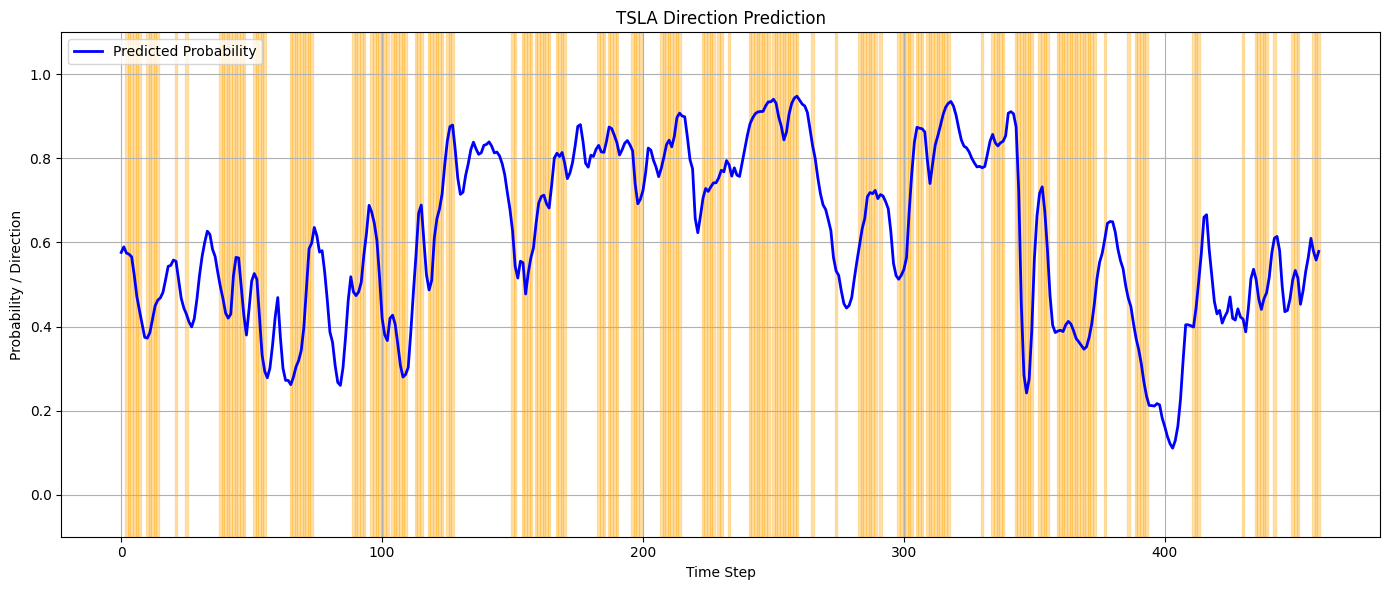

In [38]:
# Evaluate
predicted, actual, acc, f1 = evaluate_model(model, x_test, y_test)

Negative R-squared means model is worse than simply predicting the mean return for all test samples

In [ ]:
# Generate trading signals
signals = classify_signals(predicted.flatten())
print("Sample signals:", signals[:10])

Sample signals: ['Sell' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Sell']


#GRU with Attention

In [61]:
class GRUWithAttentionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3, bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1

        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0,
                          bidirectional=bidirectional)

        self.attn = nn.Linear(hidden_size * self.num_directions, 1)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_size * self.num_directions)
        self.fc = nn.Linear(hidden_size * self.num_directions, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)

        attn_scores = self.attn(out).squeeze(-1)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context = torch.sum(out * attn_weights.unsqueeze(-1), dim=1)

        out = self.dropout(context)
        out = self.norm(out)
        return self.fc(out)

In [66]:
def train_model(model, x_train, y_train, epochs=100, lr=0.0001, model_path=None, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Compute pos_weight for BCEWithLogitsLoss
    num_pos = y_train.sum().item()
    num_neg = y_train.shape[0] - num_pos
    pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train.to(device)).view(-1)
        loss = criterion(outputs, y_train.to(device).view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if verbose and (epoch + 1) % 5 == 0:
            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels = y_train.cpu().numpy().astype(int).flatten()
            acc = accuracy_score(labels, preds)
            print(f"Epoch [{epoch+1}/{epochs}]  Loss: {loss.item():.6f}  Acc: {acc:.4f}")

    # Save model
    if model_path:
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

    return model


# ----------------------------
# Evaluate Model
# ----------------------------
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, x_test, y_test, show_plot=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        logits = model(x_test.to(device)).squeeze()
        probs = torch.sigmoid(logits)
        predicted_probs = probs.cpu().numpy()
        predicted_labels = (predicted_probs >= 0.5).astype(int)
        true_labels = y_test.cpu().numpy().astype(int).flatten()

    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels)
    rec = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)

    print(f"Accuracy:    {acc:.4f}")
    print(f"Precision:   {prec:.4f}")
    print(f"Recall:      {rec:.4f}")
    print(f"F1 Score:    {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    if show_plot:
        plt.figure(figsize=(14, 6))
        plt.plot(predicted_probs, label='Predicted Probability', color='blue')
        for i, label in enumerate(true_labels):
            if label == 1:
                plt.axvline(i, color='orange', alpha=0.05)
        plt.title('TSLA Direction Prediction')
        plt.xlabel('Time Step')
        plt.ylabel('Probability / Direction')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()

    return predicted_probs, true_labels, acc, f1

In [76]:
# GRU with Attention
model = GRUWithAttentionClassifier(
    input_size=x_train.shape[2],
    hidden_size=256,
    num_layers=4,
    dropout=0.1,
    bidirectional = False
)

In [77]:
model = train_model(model, x_train, y_train, epochs=100, model_path="tsla_attention.pt")

Epoch [5/100]  Loss: 0.610256  Acc: 0.5731
Epoch [10/100]  Loss: 0.606020  Acc: 0.5399
Epoch [15/100]  Loss: 0.600892  Acc: 0.5687
Epoch [20/100]  Loss: 0.598628  Acc: 0.5714
Epoch [25/100]  Loss: 0.597245  Acc: 0.5589
Epoch [30/100]  Loss: 0.597707  Acc: 0.5741
Epoch [35/100]  Loss: 0.592576  Acc: 0.5877
Epoch [40/100]  Loss: 0.589000  Acc: 0.5932
Epoch [45/100]  Loss: 0.591521  Acc: 0.5877
Epoch [50/100]  Loss: 0.592735  Acc: 0.5932
Epoch [55/100]  Loss: 0.590654  Acc: 0.5980
Epoch [60/100]  Loss: 0.586797  Acc: 0.6056
Epoch [65/100]  Loss: 0.585181  Acc: 0.6051
Epoch [70/100]  Loss: 0.584465  Acc: 0.6018
Epoch [75/100]  Loss: 0.583217  Acc: 0.6040
Epoch [80/100]  Loss: 0.581305  Acc: 0.5964
Epoch [85/100]  Loss: 0.581561  Acc: 0.6024
Epoch [90/100]  Loss: 0.579167  Acc: 0.5942
Epoch [95/100]  Loss: 0.575580  Acc: 0.6067
Epoch [100/100]  Loss: 0.573764  Acc: 0.6062
Model saved to tsla_attention.pt


Accuracy:    0.4717
Precision:   0.4596
Recall:      0.8626
F1 Score:    0.5997
Confusion Matrix:
 [[ 35 214]
 [ 29 182]]


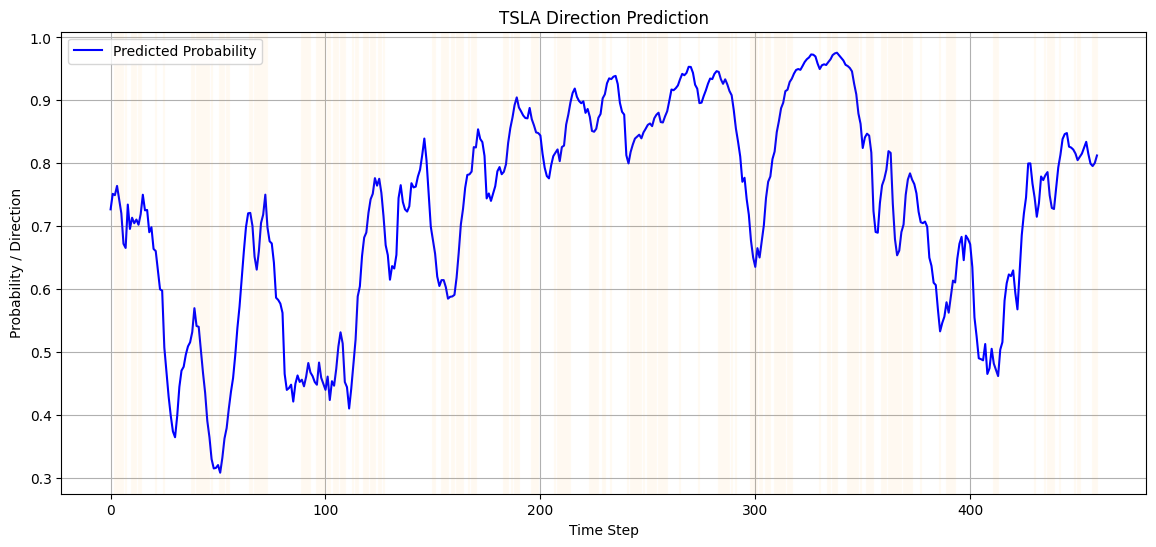

In [78]:
predicted, actual, acc, f1 = evaluate_model(model, x_test, y_test)

In [103]:
model = GRUWithAttentionClassifier(
    input_size=x_train.shape[2],
    hidden_size=128,
    num_layers=3,
    dropout=0.05,
    bidirectional = False
)
model = train_model(model, x_train, y_train, epochs=100, model_path="tsla_attention.pt")

Epoch [5/100]  Loss: 0.613611  Acc: 0.5193
Epoch [10/100]  Loss: 0.611972  Acc: 0.4992
Epoch [15/100]  Loss: 0.605141  Acc: 0.5595
Epoch [20/100]  Loss: 0.604971  Acc: 0.5714
Epoch [25/100]  Loss: 0.604649  Acc: 0.5513
Epoch [30/100]  Loss: 0.600556  Acc: 0.5617
Epoch [35/100]  Loss: 0.598119  Acc: 0.5779
Epoch [40/100]  Loss: 0.598172  Acc: 0.5682
Epoch [45/100]  Loss: 0.595205  Acc: 0.5600
Epoch [50/100]  Loss: 0.595961  Acc: 0.5703
Epoch [55/100]  Loss: 0.594540  Acc: 0.5796
Epoch [60/100]  Loss: 0.590931  Acc: 0.5807
Epoch [65/100]  Loss: 0.591639  Acc: 0.5774
Epoch [70/100]  Loss: 0.591556  Acc: 0.5823
Epoch [75/100]  Loss: 0.587046  Acc: 0.5817
Epoch [80/100]  Loss: 0.589340  Acc: 0.5910
Epoch [85/100]  Loss: 0.588645  Acc: 0.5790
Epoch [90/100]  Loss: 0.588558  Acc: 0.5828
Epoch [95/100]  Loss: 0.586913  Acc: 0.5899
Epoch [100/100]  Loss: 0.584257  Acc: 0.6089
Model saved to tsla_attention.pt


Accuracy:    0.5130
Precision:   0.4790
Recall:      0.7014
F1 Score:    0.5692
Confusion Matrix:
 [[ 88 161]
 [ 63 148]]


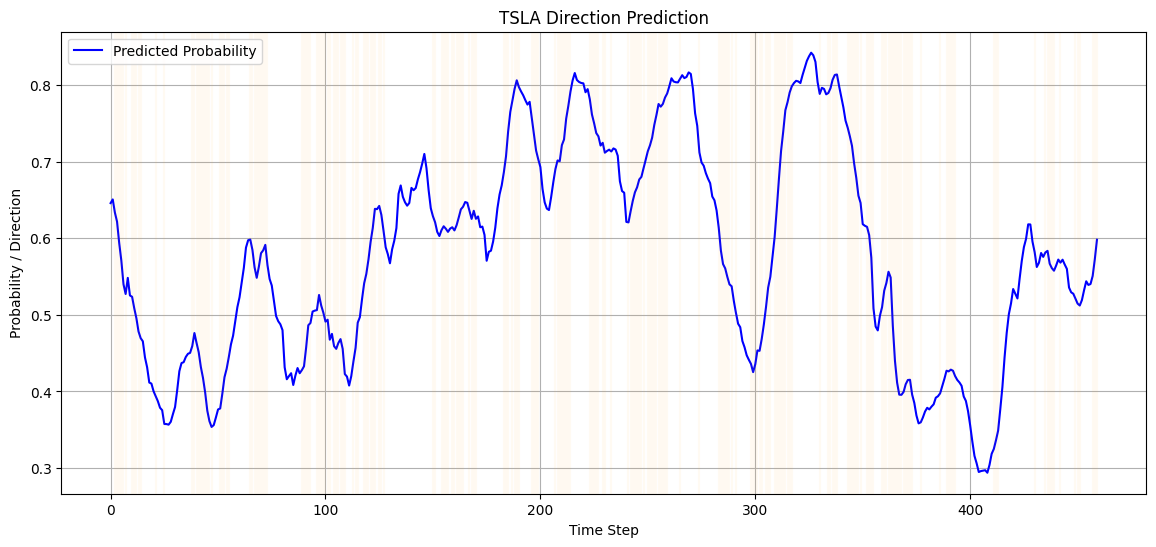

In [104]:
predicted, actual, acc, f1 = evaluate_model(model, x_test, y_test)

#LSTM-Based Return Prediction Model

In [36]:
class LSTMReturnModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(LSTMReturnModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use the last output
        return out

In [37]:
model = LSTMReturnModel(input_size = x_train.shape[2], hidden_size = 128)
model = train_model(model, x_train, y_train, epochs = 200, model_path = 'tsla_lstm_return_model.pt')

Epoch [5/200]  Loss: 0.616553  Acc: 0.4443
Epoch [10/200]  Loss: 0.615982  Acc: 0.4465
Epoch [15/200]  Loss: 0.615397  Acc: 0.4617
Epoch [20/200]  Loss: 0.614868  Acc: 0.4796
Epoch [25/200]  Loss: 0.614417  Acc: 0.5296
Epoch [30/200]  Loss: 0.614002  Acc: 0.5573
Epoch [35/200]  Loss: 0.613339  Acc: 0.5709
Epoch [40/200]  Loss: 0.612622  Acc: 0.5796
Epoch [45/200]  Loss: 0.611799  Acc: 0.5807
Epoch [50/200]  Loss: 0.610687  Acc: 0.5796
Epoch [55/200]  Loss: 0.609372  Acc: 0.5839
Epoch [60/200]  Loss: 0.607849  Acc: 0.5877
Epoch [65/200]  Loss: 0.606070  Acc: 0.5910
Epoch [70/200]  Loss: 0.604423  Acc: 0.5986
Epoch [75/200]  Loss: 0.603240  Acc: 0.5839
Epoch [80/200]  Loss: 0.601963  Acc: 0.5817
Epoch [85/200]  Loss: 0.600838  Acc: 0.5861
Epoch [90/200]  Loss: 0.599802  Acc: 0.5839
Epoch [95/200]  Loss: 0.598819  Acc: 0.5850
Epoch [100/200]  Loss: 0.597994  Acc: 0.5856
Epoch [105/200]  Loss: 0.596973  Acc: 0.5915
Epoch [110/200]  Loss: 0.595307  Acc: 0.5910
Epoch [115/200]  Loss: 0.59367

Accuracy:    0.4565
Precision:   0.4428
Recall:      0.7156
F1 Score:    0.5471
Confusion Matrix:
 [[ 59 190]
 [ 60 151]]


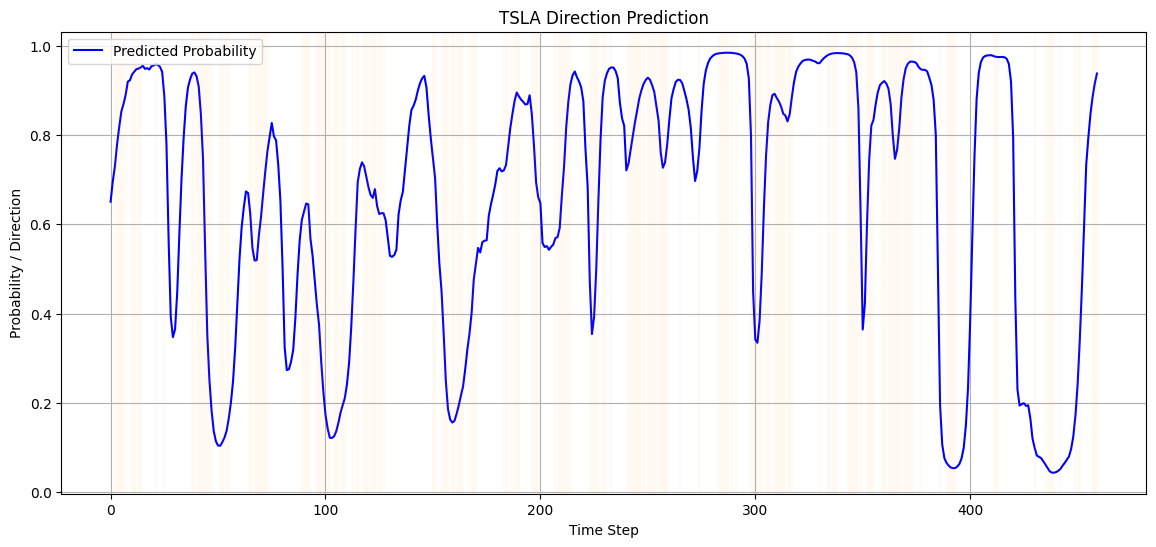

In [38]:
predicted, actual, acc, f1 = evaluate_model(model, x_test, y_test)

# Generate Prediction Table

In [41]:
features_scaled.head(5)

,Close_TSLA,QQQ,SPY,USO,US10Y,VIX,RSI,MACD,Volume_norm,Earnings,ROC,Stoch_K,Stoch_D,rolling_vol,lag_1
Date,,,,,,,,,,,,,,,
2016-01-28,-0.513476,-0.855504,-0.849922,0.032179,-0.232718,0.706876,-1.050890,-0.160690,-0.045626,0.0,-0.631304,-0.704526,-0.725806,-0.365953,-0.797269
2016-01-29,-0.513012,-0.845355,-0.827936,0.015886,-0.261214,0.439083,-0.836186,-0.160803,-0.101162,0.0,-0.644334,-0.505636,-0.691560,-0.365393,0.199113
2016-02-01,-0.511235,-0.844021,-0.828271,-0.189409,-0.242744,0.412545,-1.089873,-0.168772,-0.361190,0.0,-0.187769,-0.744657,-0.690513,-0.363642,0.178672
2016-02-02,-0.515619,-0.854790,-0.844915,-0.336049,-0.296570,0.653800,-1.191905,-0.177793,0.758455,0.0,-0.795952,-0.737104,-0.702003,-0.362282,0.773687
2016-02-03,-0.518498,-0.857125,-0.839478,-0.085132,-0.287599,0.613993,-1.370351,-0.191531,-0.082303,0.0,-1.049004,-0.879410,-0.833838,-0.359620,-1.968722


In [44]:
x_all = torch.tensor(features_scaled.values, dtype=torch.float32)

In [45]:
x_all.shape

torch.Size([2321, 15])

In [51]:
# Load model
model = GRUWithAttentionClassifier(input_size=x_all.shape[1], hidden_size=128, num_layers=2)
model.load_state_dict(torch.load('tsla_attention.pt'))
model.eval()

GRUWithAttentionClassifier(
  (gru): GRU(15, 128, num_layers=2, batch_first=True, dropout=0.3)
  (attn): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [57]:
lookback = 20  # set to whatever was used during training
x_seq_all = []
for i in range(lookback, len(x_all)):
    x_seq_all.append(x_all[i - lookback:i].unsqueeze(0))

x_seq_all = torch.cat(x_seq_all, dim=0)

In [65]:
x_all.shape

torch.Size([2321, 15])

In [63]:
x_seq_all.shape

torch.Size([2301, 20, 15])

In [58]:
# Predict
with torch.no_grad():
    logits = model(x_seq_all)
    probs = torch.sigmoid(logits.squeeze()).cpu().numpy()

In [59]:
dates = data_final.index[lookback:]
close_prices = data_final['Close_TSLA'].iloc[lookback:].values
true_direction = data_final['direction'].iloc[lookback:].values

In [60]:
# Create output dataframe
output_df = pd.DataFrame({
    'Date': dates,
    'Close': close_prices,
    'Pred_Prob': probs,
    'True_Direction': true_direction
})

In [61]:
print(len(dates), len(close_prices), len(probs), len(true_direction))

2301 2301 2301 2301


In [62]:
# Save to csv
output_df.to_csv('data_for_backtest.csv', index=False)

In [3]:
output_df = pd.read_csv("data_for_backtest.csv")

# Backtesting

In [52]:
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lag, when, lit, expr, to_date, avg, stddev

In [5]:
# Initialize Spark
spark = SparkSession.builder.appName("TSLA Alpha Signal Backtest").getOrCreate()

In [6]:
# Convert to Spark DataFrame
spark_df = spark.createDataFrame(output_df)

In [7]:
# Ensure 'Date' column is datetime
spark_df = spark_df.withColumn("Date", F.to_date("Date"))

In [8]:
spark_df.head()

Row(Date=datetime.date(2016, 2, 26), Close=-0.5132780561022977, Pred_Prob=0.61044747, True_Direction=1.0)

In [9]:
# Create a window spec for time series ops
window = Window.orderBy("Date")

In [18]:
# Generate signal
spark_df = spark_df.withColumn(
    "Signal",
    F.when(F.col("Pred_Prob") > 0.6, F.lit(1))
     .when(F.col("Pred_Prob") < 0.4, F.lit(-1))
     .otherwise(F.lit(0))
)

In [19]:
# Compute returns and strategy
spark_df = spark_df \
    .withColumn("Market_Return", F.col("Close") / F.lag("Close", 1).over(window) - 1) \
    .withColumn("Prev_Signal", F.lag("Signal", 1).over(window)) \
    .withColumn("Strategy_Return", F.col("Market_Return") * F.col("Prev_Signal"))

In [20]:
# Aggregate metrics
agg_df = spark_df.agg(
    F.avg("Strategy_Return").alias("Mean_Return"),
    F.stddev("Strategy_Return").alias("Volatility")
)

In [21]:
# Collect metrics
metrics = agg_df.collect()[0]
mean_return = metrics['Mean_Return']
volatility = metrics['Volatility']
sharpe_ratio = (mean_return / volatility) * (252**0.5) if volatility else None

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Mean Return: {mean_return:.5f}")
print(f"Volatility: {volatility:.5f}")

Sharpe Ratio: 0.33
Mean Return: 0.16181
Volatility: 7.86771


Needs tuning for better metric

In [23]:
# Extract predicted probabilities and true labels
probs = output_df['Pred_Prob'].values
true_labels = output_df['True_Direction'].values

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

In [24]:
# Apply Platt Scaling
platt_model = LogisticRegression()
platt_model.fit(probs.reshape(-1, 1), true_labels)
probs_platt = platt_model.predict_proba(probs.reshape(-1, 1))[:, 1]

In [25]:
# Apply Isotonic Regression
iso_model = IsotonicRegression(out_of_bounds='clip')
iso_model.fit(probs, true_labels)
probs_iso = iso_model.predict(probs)

In [26]:
# Calibration curves
prob_true_orig, prob_pred_orig = calibration_curve(true_labels, probs, n_bins=10)
prob_true_platt, prob_pred_platt = calibration_curve(true_labels, probs_platt, n_bins=10)
prob_true_iso, prob_pred_iso = calibration_curve(true_labels, probs_iso, n_bins=10)

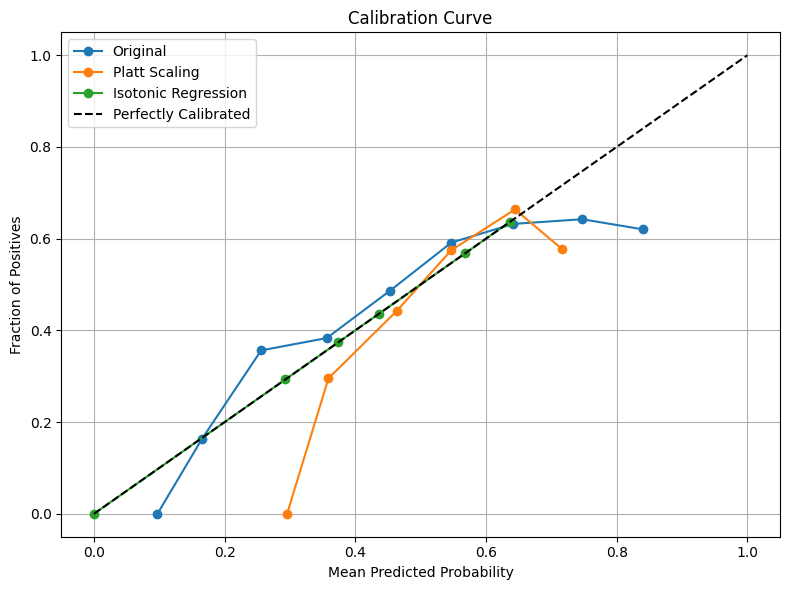

In [27]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_orig, prob_true_orig, marker='o', label='Original')
plt.plot(prob_pred_platt, prob_true_platt, marker='o', label='Platt Scaling')
plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='Isotonic Regression')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# Fit isotonic regression on original predicted probabilities and true labels
iso_model.fit(output_df["Pred_Prob"], output_df["True_Direction"])

# Generate calibrated probabilities
output_df["Pred_Prob_Calibrated"] = iso_model.predict(output_df["Pred_Prob"])

# Save the calibrated dataset
output_df.to_csv("backtest_calibrated.csv", index=False)

In [33]:
# Initialize Spark session
spark = SparkSession.builder.appName("TSLA_Backtest_Calibrated").getOrCreate()

# Load calibrated CSV
df_calibrated = pd.read_csv("backtest_calibrated.csv")
df_spark = spark.createDataFrame(df_calibrated)

# Add trading signal: long if Calibrated_Prob > 0.5, else short
df_spark = df_spark.withColumn("Position", when(col("Pred_Prob_Calibrated") > 0.5, lit(1)).otherwise(lit(-1)))

# Add lagged close price
window_spec = Window.orderBy("Date")
df_spark = df_spark.withColumn("Prev_Close", lag("Close").over(window_spec))

# Calculate returns and strategy returns
df_spark = df_spark.withColumn("Return", (col("Close") - col("Prev_Close")) / col("Prev_Close"))
df_spark = df_spark.withColumn("Strategy_Return", col("Return") * col("Position"))

# Convert to Pandas
df_result = df_spark.dropna().toPandas()

# Evaluate performance
mean_return = df_result["Strategy_Return"].mean()
volatility = df_result["Strategy_Return"].std()
sharpe_ratio = mean_return / volatility if volatility != 0 else np.nan

# Print results
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Mean Return: {mean_return:.5f}")
print(f"Volatility: {volatility:.5f}")

Sharpe Ratio: 0.03
Mean Return: 0.25445
Volatility: 8.91649


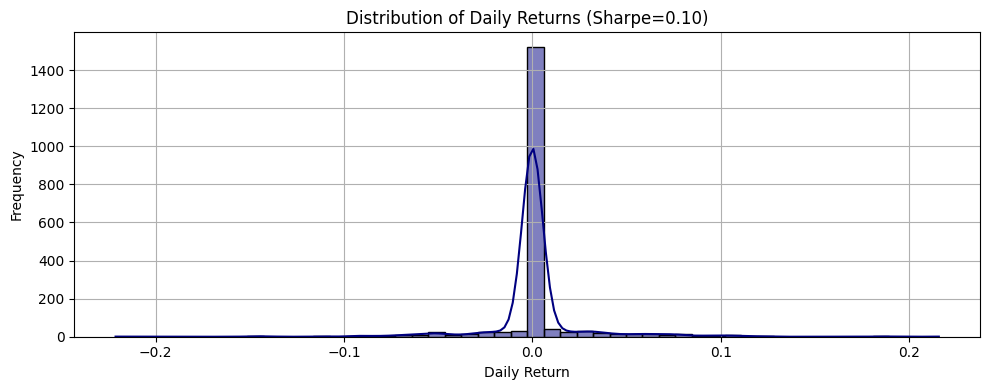

In [48]:
output_df["Date"] = pd.to_datetime(output_df["Date"])

# Grid search to optimize Sharpe ratio
best_sharpe = -np.inf
best_thresh_up = None
best_thresh_down = None
best_result = None

for thresh_up in np.arange(0.50, 0.70, 0.01):
    for thresh_down in np.arange(0.30, 0.50, 0.01):
        if thresh_down >= thresh_up:
            continue
        output_df["Position"] = 0
        output_df.loc[output_df["Pred_Prob_Calibrated"] > thresh_up, "Position"] = 1
        output_df.loc[output_df["Pred_Prob_Calibrated"] < thresh_down, "Position"] = -1

        output_df["Daily_Return"] = output_df["Position"].shift(1) * output_df["Close"].diff()
        output_df.dropna(inplace=True)

        mean_return = output_df["Daily_Return"].mean()
        volatility = output_df["Daily_Return"].std()
        sharpe_ratio = mean_return / volatility if volatility != 0 else 0

        if sharpe_ratio > best_sharpe:
            best_sharpe = sharpe_ratio
            best_thresh_up = thresh_up
            best_thresh_down = thresh_down
            best_result = (mean_return, volatility, sharpe_ratio)

# Plot distribution
plt.figure(figsize=(10, 4))
sns.histplot(output_df["Daily_Return"], kde=True, bins=50, color='navy')
plt.title(f"Distribution of Daily Returns (Sharpe={best_sharpe:.2f})")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# Report best thresholds and performance
print(f"Best Sharpe Ratio: {best_sharpe:.2f}")
print(f"Thresholds: Buy if > {best_thresh_up}, Sell if < {best_thresh_down}")
print(f"Mean Return: {best_result[0]:.5f}")
print(f"Volatility: {best_result[1]:.5f}")

Best Sharpe Ratio: 0.10
Thresholds: Buy if > 0.5900000000000001, Sell if < 0.47000000000000014
Mean Return: 0.00308
Volatility: 0.03130


# Optimize Thresholds, additionally

In [53]:
# Start Spark session
spark = SparkSession.builder.appName("TSLA Alpha Optimization").getOrCreate()

# Load the dataset
df = spark.read.csv("data_for_backtest.csv", header=True, inferSchema=True)
df = df.withColumn("Date", to_date("Date"))

# Define lag window
window = Window.orderBy("Date")

# Initialize best Sharpe tracker
best_sharpe = float("-inf")
best_upper = None
best_lower = None

# Loop through threshold pairs
for upper in np.arange(0.5, 0.9, 0.01):
    for lower in np.arange(0.1, 0.5, 0.01):
        if lower >= upper:
            continue

        # Generate signals
        temp_df = df.withColumn(
            "Signal",
            when(col("Pred_Prob") > upper, lit(1))
            .when(col("Pred_Prob") < lower, lit(-1))
            .otherwise(lit(0))
        )

        # Calculate returns
        temp_df = temp_df \
            .withColumn("Market_Return", col("Close") / lag("Close", 1).over(window) - 1) \
            .withColumn("Prev_Signal", lag("Signal", 1).over(window)) \
            .withColumn("Strategy_Return", col("Market_Return") * col("Prev_Signal"))

        # Aggregate metrics
        agg_df = temp_df.agg(
            avg("Strategy_Return").alias("Mean_Return"),
            stddev("Strategy_Return").alias("Volatility")
        )

        metrics = agg_df.collect()[0]
        mean_return = metrics["Mean_Return"]
        volatility = metrics["Volatility"]

        if volatility and volatility != 0:
            sharpe = (mean_return / volatility) * (252**0.5)
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_upper = upper
                best_lower = lower

# Final output
print(f"Best Sharpe: {best_sharpe:.3f}")
print(f"Upper Threshold: {best_upper}, Lower Threshold: {best_lower}")

Best Sharpe: 0.874
Upper Threshold: 0.8800000000000003, Lower Threshold: 0.19999999999999996


# ***Integrate LangChain***

In [ ]:
from langchain.chains.summarize import load_summarize_chain
chain = load_summarize_chain(llm, chain_type="map_reduce")
summary = chain.run(transcript_text)